In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

baseline_model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [3]:
model=baseline_model

In [5]:
chat = [
  {"role": "user", "content": "What's the fifth prime?"},
]

In [16]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

"<｜begin▁of▁sentence｜><｜User｜>What's the fifth prime?<｜Assistant｜><think>\n"

In [11]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True)

[128000, 128011, 3923, 596, 279, 18172, 10461, 30, 128012, 128013, 198]

In [17]:
output = model.generate(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    max_new_tokens=50,
    do_sample=False,
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 12.77it/s]


In [19]:
print(output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
To determine the fifth prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the first prime number.

Next, 3 is also a prime number since it has no divisors other than 1


In [20]:
logits = model(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    return_type='logits',
)
print(logits.shape)

torch.Size([1, 12, 128256])


In [25]:
probs = logits[0, -1, :].softmax(dim=-1)

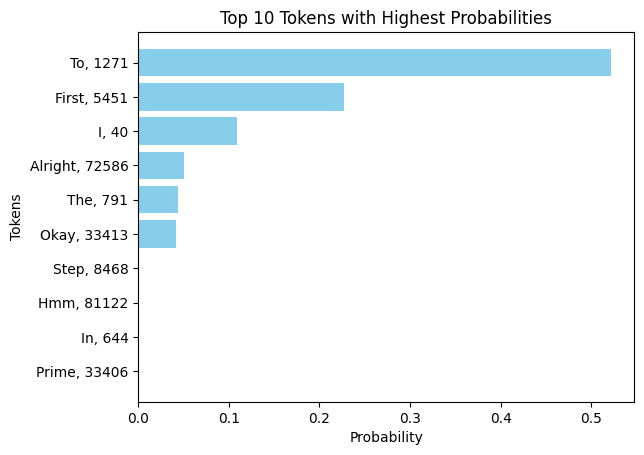

In [29]:
# Assuming `probs` is a tensor of probabilities and `model.tokenizer` is defined
topk = 10  # Number of top tokens to visualize
topk_probs, topk_indices = probs.topk(topk)  # Get top-k probabilities and their indices

# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.tokenizer.decode([idx])}, {idx}" for idx in topk_indices]

# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()

# Plot the bar chart
import matplotlib.pyplot as plt

plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('Probability')
plt.ylabel('Tokens')
plt.title('Top 10 Tokens with Highest Probabilities')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.show()

Note: 

to do this rigorously 

compute probabilities over N (16, 32 prompts)

and use the outputs over those 
this controls for different output probabilities between different prompts 

look at variance between prmopts to make sure that your metrics 



In [31]:
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

In [32]:
model.to_string(neg_features[0])

'Okay'

In [34]:
for feat in pos_features:
    print(model.to_string(feat))

To
To find
To determine
**Solution:


write a function which takes in a list of lists of tokens 

promtp = "do this"

eg: 
pos_features = [
    [12,],
    [13, 128]
]

negative_feats = [...]

log_prob(pos_feats) - log_prob(prompt+neg_feats) 


appends each to the end of a prompt, and returns their

In [ ]:

def compute_feature_mode_metric(
    model: HookedTransformer,
    prompt: str,
    pos_features: list[list[int]],
    neg_features: list[list[int]],
):
    """
    Computes:
      - normalized probabilities for each feature sequence (sum to 1)
      - unnormalized log-scores for each
      - logit (log-odds) of producing any negative feature.
    Uses model.to_tokens() for tokenization.
    """
    device = model.cfg.device
    # 1) Tokenize prompt with the built-in hook
    #    (adds BOS if the model is configured to)
    input_ids = model.to_tokens(prompt).to(device)

    # 2) Score one feature sequence by accumulating log-probs
    def sequence_score(feature: list[int]) -> torch.Tensor:
        ctx = input_ids.clone()
        total_log_prob = torch.tensor(0.0, device=device)
        for tok in feature:
            # run the model on the current context
            logits, activations = model.run_with_cache(ctx) #turn off this 
            last_logits = logits[:, -1, :]  # [1, vocab_size]
            log_probs = torch.log_softmax(last_logits, dim=-1)
            total_log_prob = total_log_prob + log_probs[0, tok]
            # append the ground-truth token to the context
            ctx = torch.cat([ctx, torch.tensor([[tok]], device=device)], dim=1)
        return total_log_prob

    # 3) Compute scores for all features
    all_features = pos_features + neg_features
    scores = torch.stack([sequence_score(f) for f in all_features])  # (n+m,)

    # 4) Softmax to get normalized probabilities
    norm_probs = torch.softmax(scores, dim=0)                        # (n+m,)

    # 5) Sum up the negative-feature mass & compute logit
    num_pos   = len(pos_features)
    neg_prob  = norm_probs[num_pos:].sum()
    neg_logit = torch.log(neg_prob) - torch.log(1 - neg_prob)

    return norm_probs, scores, neg_logit




In [5]:
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

for pf in pos_features:
    print(model.to_string(pf))

print("\n\n")

for nf in neg_features:
    print(model.to_string(nf))

To
To find
To determine
**Solution:



Okay


In [6]:

prompt       = "<｜User｜>What is 8/4<｜Assistant｜><think>\n"
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

norm_probs, scores, neg_logit = compute_feature_mode_metric(
    model, prompt, pos_features, neg_features
)

print("Normalized probabilities:", norm_probs)
print("Unnormalized log-scores:", scores)
print("Negative-feature logit:", neg_logit)

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 44.34 GiB of which 24.81 MiB is free. Process 2410955 has 44.31 GiB memory in use. Of the allocated memory 43.97 GiB is allocated by PyTorch, and 32.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

prompt       = "<｜User｜>What is 8/4<｜Assistant｜><think>\nOkay, I know 8/4=2\n</think>s"
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

norm_probs, scores, neg_logit = compute_feature_mode_metric(
    model, prompt, pos_features, neg_features
)

print("Normalized probabilities:", norm_probs)
print("Unnormalized log-scores:", scores)
print("Negative-feature logit:", neg_logit)